In [1]:
import sys
from pathlib import Path
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
from skimage import filters

%load_ext autoreload
%autoreload 2
sys.path.append('../src/')
import proj

In [674]:
eval = proj.FilterEvaluator('../data/stage1/')
eval.run()

[(23.0978062049753, 0.7825716650293523, 'gaussian_blur'), (21.304490317146406, 0.6311978529070833, 'gaussian_noise'), (20.761952953921245, 0.6783023296639293, 'motion_blur'), (26.765740881545092, 0.9232724604869724, 'sp_noise'), (23.28552204396715, 0.7666485298882151, 'speckle_noise')]
gaussian_blur: PASS
	Goal: PSNR=20.50, SSIM=0.65
	Actual: PSNR=23.10, SSIM=0.78

gaussian_noise: PASS
	Goal: PSNR=19.50, SSIM=0.60
	Actual: PSNR=21.30, SSIM=0.63

motion_blur: FAIL
	Goal: PSNR=21.50, SSIM=0.70
	Actual: PSNR=20.76, SSIM=0.68

sp_noise: PASS
	Goal: PSNR=26.50, SSIM=0.90
	Actual: PSNR=26.77, SSIM=0.92

speckle_noise: PASS
	Goal: PSNR=20.00, SSIM=0.65
	Actual: PSNR=23.29, SSIM=0.77



{'gaussian_blur': (23.0978062049753, 0.7825716650293523),
 'gaussian_noise': (21.304490317146406, 0.6311978529070833),
 'motion_blur': (20.761952953921245, 0.6783023296639293),
 'sp_noise': (26.765740881545092, 0.9232724604869724),
 'speckle_noise': (23.28552204396715, 0.7666485298882151)}

# Old Method Involving Gaussian PSF Estimation
Finding Gaussian kernel: https://dsp.stackexchange.com/questions/35768/estimating-the-standard-deviation-of-gaussian-filter-from-smoothed-image  

In [ ]:
%reload_ext autoreload
import proj
filt = proj.Filters('../data/stage1/')
# ret = filt.evaluate()
# filt.evaluate('gaussian_blur')

a = 1.0

# fit a gaussian to the first row of the gaussians
def fourier_gaussian(x, sigma, mean=0.0):
    return a * np.exp(-2*(np.pi*(x-mean)*sigma)**2)


def gaussian1d(x, a, x0, sigma):
    return a * np.exp(-(x-x0)**2 / (2*sigma**2))


def gaussian2d(h: int, w: int, sigma: float, a: float = 1.0) -> np.ndarray:
    """Create a 2D Gaussian filter.
    """
    x = np.linspace(-w/2, w/2, w)
    y = np.linspace(-h/2, h/2, h)
    X, Y = np.meshgrid(x, y)
    ret = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    return a * ret / np.sum(ret)

gaussian_avg = []
for i in range(len(filt.imgs_truth)):
    img_blur = filt.imgs['gaussian_blur'][i]
    img_truth = filt.imgs_truth[i]

    img_blur_fft = np.fft.fft2(img_blur)
    img_truth_fft = np.fft.fft2(img_truth)

    tol = 1e-2
    img_truth_fft = np.where(np.abs(img_truth_fft) < tol, tol, img_truth_fft)
    div = np.abs(img_blur_fft / img_truth_fft)
    gaussians = np.fft.fftshift(np.abs(div[0,:]))

    for j in range(3):
        gaussian_avg.append(gaussians[:,j])

gaussian_avg = np.array(gaussian_avg)
gaussian_avg = np.median(gaussian_avg, axis=0)
N = gaussian_avg.shape[0]

# Smooth signal
gaussian_avg = savgol_filter(gaussian_avg, 20, 1)

# # Set left and right ends of signal to 0
# maxval = np.max(gaussian_avg)
# for i in range(N//2-1):
#     if gaussian_avg[i] < maxval/35:
#         gaussian_avg[N//2+i:] = 0
#         gaussian_avg[:N//2-i] = 0
#         break

sigma = 0.7
x = np.linspace(-np.pi, np.pi, N)
plt.plot(x, gaussian_avg)
y = fourier_gaussian(x, sigma)
plt.plot(x, y)

h, w, = img_blur.shape[:2]
psf = gaussian2d(h, w, sigma)
print("psf min/max: ", psf.max(), psf.min())

n = gaussian_avg.shape[0]
x = np.linspace(-n/2, n/2, n)
popt, pcov = curve_fit(fourier_gaussian, x, gaussian_avg)
sigma = abs(popt[0])
print(a, sigma, 1/sigma)

# New Method of Gaussian PSF Estimation

In [ ]:
eval = proj.FilterEvaluator('../data/stage1/')
print(proj.calc_gaussian_blur_sigma(eval.imgs['truth'], eval.imgs['gaussian_blur']))

[(20.73013908466964, 0.6774313563055437, 'motion_blur')]
motion_blur: FAIL
	Goal: PSNR=21.50, SSIM=0.70
	Actual: PSNR=20.73, SSIM=0.68



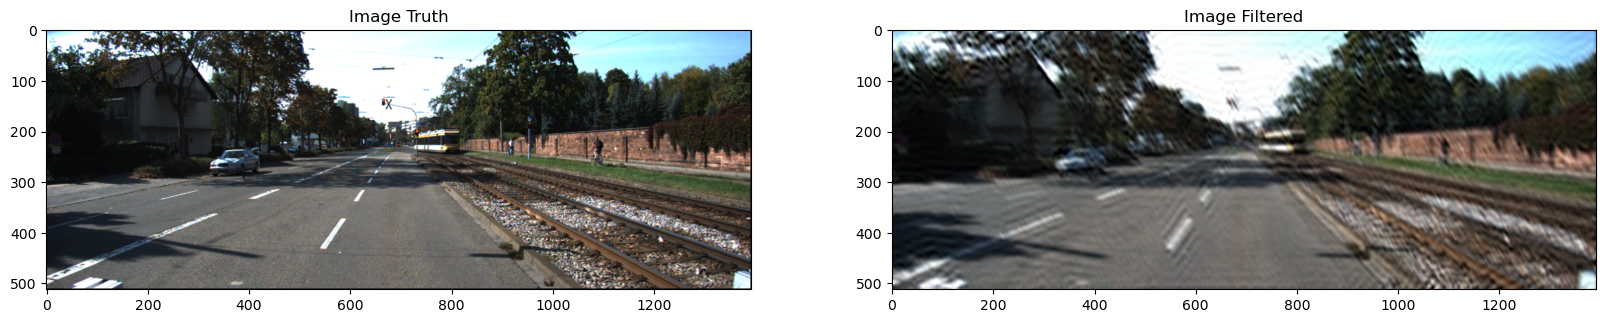

In [498]:
%reload_ext autoreload
import proj
eval = proj.FilterEvaluator('../data/stage1/')
# eval.run()
# eval.run('sp_noise')
eval.run('motion_blur')
eval.plot('motion_blur')
plt.show()

Benchmark: PSNR: 26.6, SSIM: 0.65
Filtered:  PSNR: 23.08, SSIM: 0.79


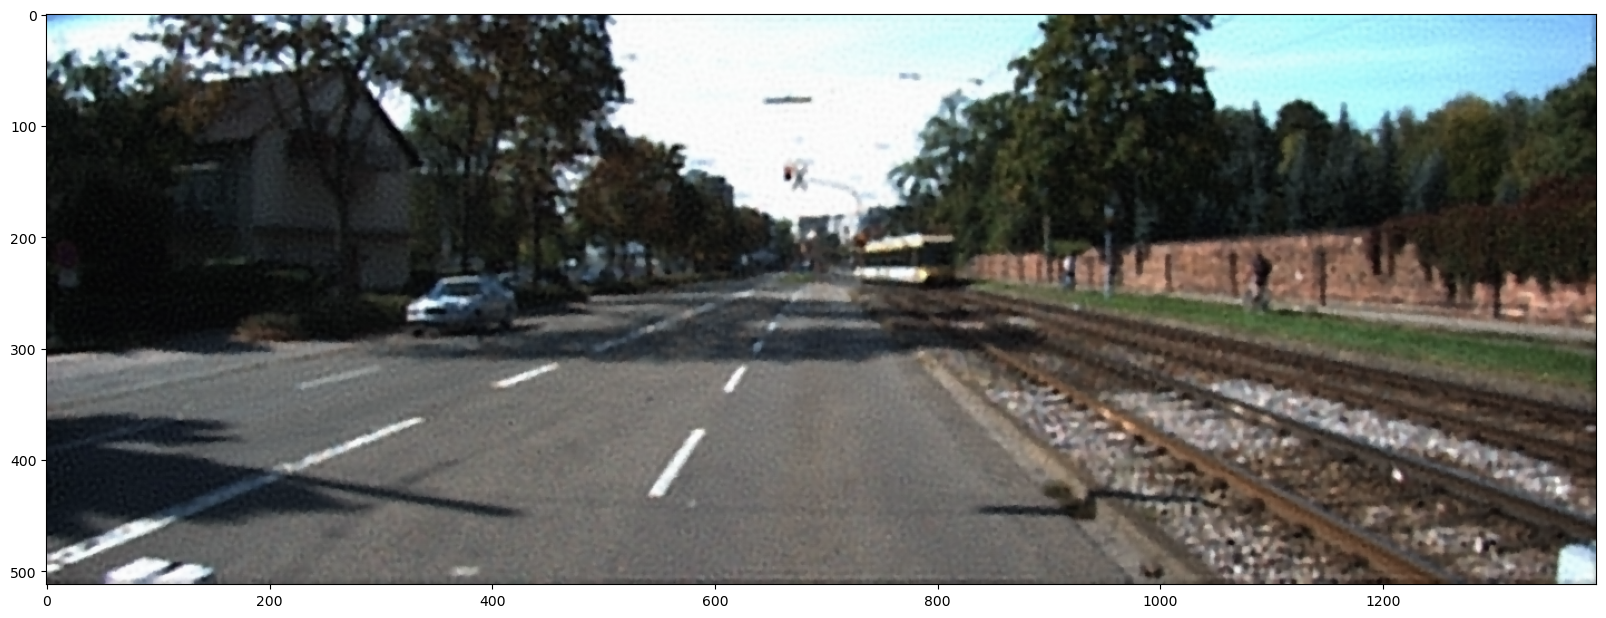

In [397]:
# Function setup
from skimage import filters, restoration
from skimage.util import img_as_float, img_as_ubyte
eval = proj.FilterEvaluator('../data/stage1/')
img_truth = eval.imgs_truth[0]
img = eval.imgs['gaussian_blur'][0]
def _gaussian2d(h: int, w: int, sigma: float, a: float = 1.0) -> np.ndarray:
    """Create a 2D Gaussian filter.
    """
    x = np.linspace(-w/2, w/2, w)
    y = np.linspace(-h/2, h/2, h)
    X, Y = np.meshgrid(x, y)
    ret = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    return a * ret / np.sum(ret)


# Run filtering
# TODO: try with a smaller gaussian kernel
output_img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
pd = 30
output_img = cv2.copyMakeBorder(output_img, pd, pd, pd, pd, cv2.BORDER_REFLECT)
sigma = 3.6
# h, w = 41, 41
# h, w = 63, 63
psf = _gaussian2d(h, w, sigma=sigma)
output_img = 2*(output_img/255) - 1

output_img[:,:,0] = restoration.unsupervised_wiener(output_img[:,:,0], psf, clip=True)[0]

output_img = np.uint8(255/2*(output_img + 1))
output_img = output_img[pd:-pd, pd:-pd]
output_img = cv2.cvtColor(output_img, cv2.COLOR_YUV2RGB)

output_img = cv2.bilateralFilter(output_img, 7, 75, 150) # 75, 150 best

psnr = proj.calc_psnr(img_truth, output_img)
ssim = proj.calc_ssim(img_truth, output_img)
print(f'Benchmark: PSNR: 26.6, SSIM: 0.65')
print(f'Filtered:  PSNR: {psnr:.2f}, SSIM: {ssim:.2f}')


# Plot
plt.figure(figsize=(20,10))
plt.imshow(output_img)

# Estimate Motion Blur

Calculated through a grid search maximizing SSIM  

estimated kernel size: 19, estimated angle: -73

In [ ]:
# Setup inputs
imgs_truth = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in eval.imgs_truth])
imgs_blur = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in eval.imgs['motion_blur']])

# Test all motion blur kernel varioations
# kernel_sizes = [3, 5, 7, 9, 19, 39, 79, 159, 319, 511]
# angles = np.linspace(-180, 180, 37)
# got 19, -70 for the coarse grained run, and 19,-73 for the fine grained run
kernel_sizes = [11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37]
angles = np.arange(-80, -59)

outputs = []
for kernel_size in tqdm(kernel_sizes):
    for angle in angles:
        kernel = proj.create_motion_blur_kernel(kernel_size, angle)
        imgs_est_blur = np.array([cv2.filter2D(img, -1, kernel) for img in imgs_truth])
        ssim = proj.calc_ssim(imgs_blur, imgs_est_blur)
        outputs.append((kernel_size, angle, ssim))

# Print/Plot results
outputs = np.array(outputs)
minidx = np.argmax(outputs[:,2])
print(outputs[minidx])
kernel = create_motion_blur_kernel(int(outputs[minidx,0]), int(outputs[minidx,1]))
print(kernel)
img = cv2.filter2D(imgs_truth[0], -1, kernel)
plt.figure(figsize=(20,10))
plt.imshow(img, cmap='gray')

[(20.761952953921245, 0.6783023296639293, 'motion_blur')]
motion_blur: FAIL
	Goal: PSNR=21.50, SSIM=0.70
	Actual: PSNR=20.76, SSIM=0.68



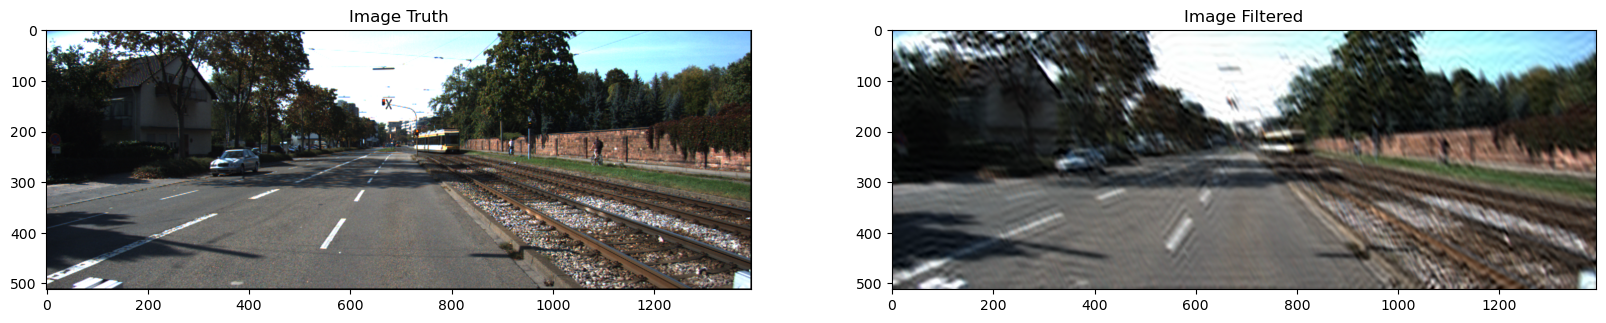

In [655]:
%reload_ext autoreload
import proj
eval = proj.FilterEvaluator('../data/stage1/')
# eval.run()
# eval.run('sp_noise')
eval.run('motion_blur')
eval.plot('motion_blur')
plt.show()

Benchmark: PSNR: 21.5, SSIM: 0.70
Filtered:  PSNR: 20.97, SSIM: 0.70


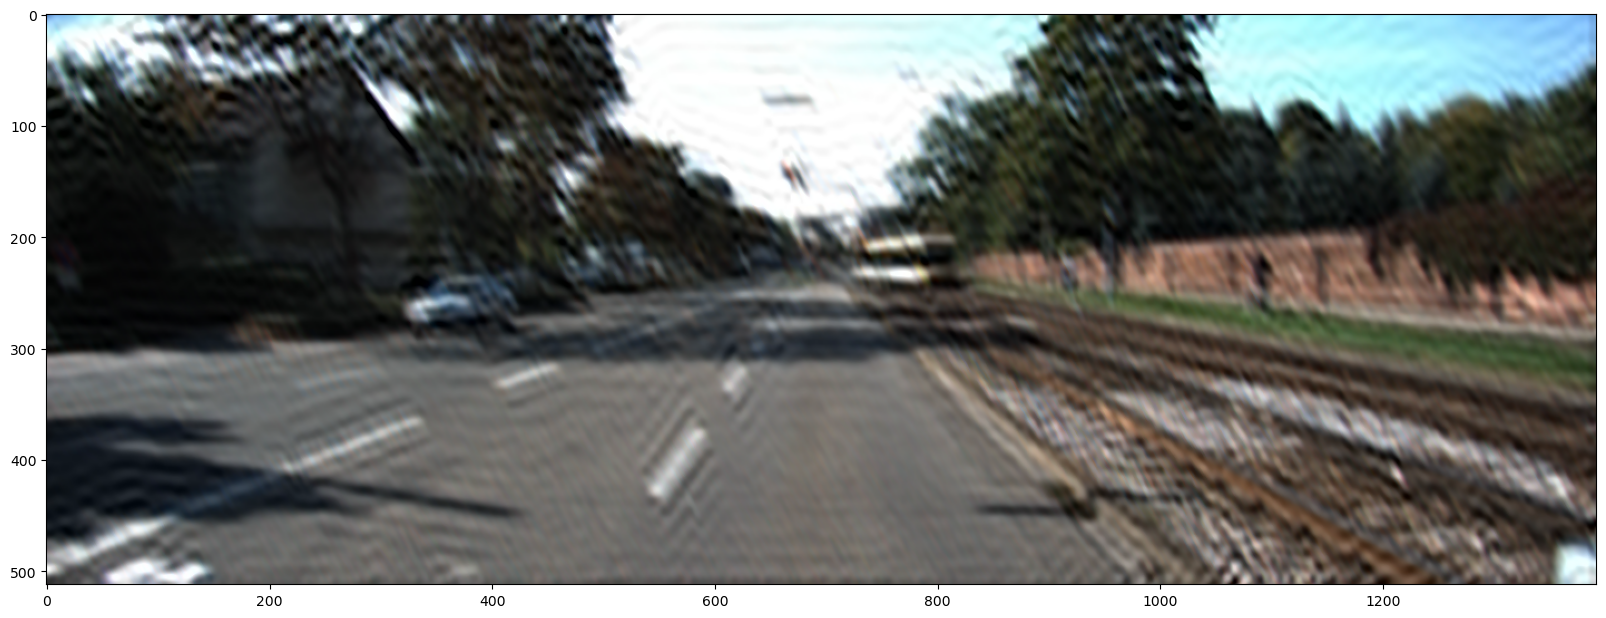

In [667]:
from skimage import exposure
img = eval.imgs['motion_blur'][0]
img_truth = eval.imgs_truth[0]



kernel = create_motion_blur_kernel(kernel_size=19, angle=-75)

output_img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
# output_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

pd = 100
output_img = cv2.copyMakeBorder(output_img, pd, pd, pd, pd, cv2.BORDER_REFLECT)
output_img = 2*(output_img/255) - 1

output_img[:,:,0] = restoration.wiener(output_img[:,:,0], kernel, balance=0.5, clip=True)
# output_img[:,:,2] = restoration.wiener(output_img[:,:,2], kernel, balance=0.5, clip=True)
# output_img[:,:,1] = restoration.wiener(output_img[:,:,1], kernel, balance=1.0, clip=True)
# output_img[:,:,0] = restoration.wiener(output_img[:,:,0], kernel, balance=0.5, clip=True)

output_img = np.uint8(255/2*(output_img + 1))
output_img = output_img[pd:-pd, pd:-pd]
output_img = cv2.cvtColor(output_img, cv2.COLOR_YUV2RGB)
# output_img = cv2.cvtColor(output_img, cv2.COLOR_HSV2RGB)
output_img = cv2.bilateralFilter(output_img, 3, 15, 150) # 75, 150 best

# output_img = proj.filter_gaussian_blur(output_img, 5, 19, 19)


psnr = proj.calc_psnr(img_truth, output_img)
ssim = proj.calc_ssim(img_truth, output_img)
print(f'Benchmark: PSNR: 21.5, SSIM: 0.70')
print(f'Filtered:  PSNR: {psnr:.2f}, SSIM: {ssim:.2f}')


# Plot
plt.figure(figsize=(20,10))
plt.imshow(output_img)